# RL and Advanced DL: Домашнее задание 2

## Imports & TicTacToe env

In [1]:
import copy
import gym

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.autograd import Variable
import tqdm

In [2]:
import imp
import os
path="/content/drive/MyDrive/MADE/3-dl-rl/hw2"
os.chdir(path)
os.listdir(path)

['DL_RL_HW2.ipynb', '__pycache__', '.ipynb_checkpoints', 'TicTacToeClasses.py']

In [3]:
N_ROWS, N_COLS, N_WIN = 3, 3, 3

In [4]:
class TicTacToe(gym.Env):
    def __init__(self, n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN, clone=None):
        if clone is not None:
            self.n_rows, self.n_cols, self.n_win = clone.n_rows, clone.n_cols, clone.n_win
            self.board = copy.deepcopy(clone.board)
            self.curTurn = clone.curTurn
            self.emptySpaces = None
            self.boardHash = None
        else:
            self.n_rows = n_rows
            self.n_cols = n_cols
            self.n_win = n_win

            self.reset()

    def getEmptySpaces(self):
        if self.emptySpaces is None:
            res = np.where(self.board == 0)
            self.emptySpaces = np.array([ (i, j) for i,j in zip(res[0], res[1]) ])
        return self.emptySpaces

    def makeMove(self, player, i, j):
        self.board[i, j] = player
        self.emptySpaces = None
        self.boardHash = None

    def getHash(self):
        if self.boardHash is None:
            self.boardHash = ''.join(['%s' % (x+1) for x in self.board.reshape(self.n_rows * self.n_cols)])
        return self.boardHash

    def isTerminal(self):
        # проверим, не закончилась ли игра
        cur_marks, cur_p = np.where(self.board == self.curTurn), self.curTurn
        for i,j in zip(cur_marks[0], cur_marks[1]):
            win = False
            if i <= self.n_rows - self.n_win:
                if np.all(self.board[i:i+self.n_win, j] == cur_p):
                    win = True
            if not win:
                if j <= self.n_cols - self.n_win:
                    if np.all(self.board[i,j:j+self.n_win] == cur_p):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j <= self.n_cols - self.n_win:
                    if np.all(np.array([ self.board[i+k,j+k] == cur_p for k in range(self.n_win) ])):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j >= self.n_win-1:
                    if np.all(np.array([ self.board[i+k,j-k] == cur_p for k in range(self.n_win) ])):
                        win = True
            if win:
                self.gameOver = True
                return self.curTurn

        if len(self.getEmptySpaces()) == 0:
            self.gameOver = True
            return 0

        self.gameOver = False
        return None

    def printBoard(self):
        for i in range(0, self.n_rows):
            print('----'*(self.n_cols)+'-')
            out = '| '
            for j in range(0, self.n_cols):
                if self.board[i, j] == 1:
                    token = 'x'
                if self.board[i, j] == -1:
                    token = 'o'
                if self.board[i, j] == 0:
                    token = ' '
                out += token + ' | '
            print(out)
        print('----'*(self.n_cols)+'-')

    def getState(self):
        return (self.getHash(), self.getEmptySpaces(), self.curTurn)

    def action_from_int(self, action_int):
        return ( int(action_int / self.n_cols), int(action_int % self.n_cols))

    def int_from_action(self, action):
        return action[0] * self.n_cols + action[1]
    
    def step(self, action):
        if self.board[action[0], action[1]] != 0:
            return self.getState(), -10, True, {}
        self.makeMove(self.curTurn, action[0], action[1])
        reward = self.isTerminal()
        self.curTurn = -self.curTurn
        return self.getState(), 0 if reward is None else reward, reward is not None, {}

    def reset(self):
        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.boardHash = None
        self.gameOver = False
        self.emptySpaces = None
        self.curTurn = 1

In [5]:
def plot_board(env, pi, showtext=True, verbose=True, fontq=20, fontx=60):
    '''Рисуем доску с оценками из стратегии pi'''
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    X, Y = np.meshgrid(np.arange(0, env.n_rows), np.arange(0, env.n_rows))
    Z = np.zeros((env.n_rows, env.n_cols)) + .01
    s, actions = env.getHash(), env.getEmptySpaces()
    if pi is not None and s in pi.Q:
        for i, a in enumerate(actions):
            Z[a[0], a[1]] = pi.Q[s][i]
    ax.set_xticks([])
    ax.set_yticks([])
    surf = ax.imshow(Z, cmap=plt.get_cmap('Accent', 10), vmin=-1, vmax=1)
    if showtext:
        for i,a in enumerate(actions):
            if pi is not None and s in pi.Q:
                ax.text( a[1] , a[0] , "%.3f" % pi.Q[s][i], fontsize=fontq, horizontalalignment='center', verticalalignment='center', color="w" )
    for i in range(env.n_rows):
        for j in range(env.n_cols):
            if env.board[i, j] == -1:
                ax.text(j, i, "O", fontsize=fontx, horizontalalignment='center', verticalalignment='center', color="w" )
            if env.board[i, j] == 1:
                ax.text(j, i, "X", fontsize=fontx, horizontalalignment='center', verticalalignment='center', color="w" )
    cbar = plt.colorbar(surf, ticks=[0, 1])
    ax.grid(False)
    plt.show()

def get_and_print_move(env, pi, s, actions, random=False, verbose=True, fontq=20, fontx=60):
    '''Делаем ход, рисуем доску'''
    plot_board(env, pi, fontq=fontq, fontx=fontx)
    if verbose and (pi is not None):
        if s in pi.Q:
            for i,a in enumerate(actions):
                print(i, a, pi.Q[s][i])
        else:
            print("Стратегия не знает, что делать...")
    if random:
        return np.random.randint(len(actions))
    else:
        return pi.getActionGreedy(s, len(actions))

In [6]:
def plot_test_game(env, pi1, pi2, random_crosses=False, random_naughts=True, verbose=True, fontq=20, fontx=60):
    '''Играем тестовую партию между стратегиями или со случайными ходами, рисуем ход игры'''
    done = False
    env.reset()
    while not done:
        s, actions = env.getHash(), env.getEmptySpaces()
        if env.curTurn == 1:
            a = get_and_print_move(env, pi1, s, actions, random=random_crosses, verbose=verbose, fontq=fontq, fontx=fontx)
        else:
            a = get_and_print_move(env, pi2, s, actions, random=random_naughts, verbose=verbose, fontq=fontq, fontx=fontx)
        observation, reward, done, info = env.step(actions[a])
        if reward == 1:
            print("Крестики выиграли!")
            plot_board(env, None, showtext=False, fontq=fontq, fontx=fontx)
        if reward == -1:
            print("Нолики выиграли!")
            plot_board(env, None, showtext=False, fontq=fontq, fontx=fontx)

## Часть первая: крестики-нолики при помощи Q-обучения

### 1. Реализуйте обычное (табличное) Q-обучение. Обучите стратегии крестиков и ноликов для доски 3х3.

Реализуем Q-обучение с двумя политиками: первого и второго игрока.

In [7]:
def get_action(p, board_hash, empty_spaces, epsilon):
  empty_len = len(empty_spaces)
  if board_hash in p.Q and np.random.random() > epsilon:
    idx = np.argmax(p.Q[board_hash])
  else:
    idx = np.random.randint(empty_len)
    if board_hash not in p.Q:
      p.Q[board_hash] = np.zeros(empty_len)
  a = empty_spaces[idx]
  return a, idx

In [8]:
def QLearning(env, p_1, p_2, alpha=0.009, epsilon=0.3, gamma=1.0):
  env.reset()
  board_hash, empty_spaces, cur_turn = env.getState()
  reward, done = 0, False
  p_1_prev_s, p_1_prev_a = None, None
  p_2_prev_s, p_2_prev_a = None, None

  while not done:
      
    if cur_turn == 1:
      a, idx = get_action(p_1, board_hash, empty_spaces, epsilon)
      state, reward, done, _ = env.step(a)
      board_hash_main, empty_spaces_main, cur_turn_main = state
      
      if p_2_prev_s:
        gamma_t = gamma * np.max(p_2.Q[board_hash_main]) if board_hash_main in p_2.Q else 0
        p_2.Q[p_2_prev_s][p_2_prev_a] = p_2.Q[p_2_prev_s][p_2_prev_a] + alpha * (-reward + gamma_t - p_2.Q[p_2_prev_s][p_2_prev_a])
      if reward == 1:
        p_1.Q[board_hash][idx] = reward
      
      p_1_prev_s, p_1_prev_a = board_hash, idx

    elif cur_turn == -1:
      a, idx = get_action(p_2, board_hash, empty_spaces, epsilon)
      state, reward, done, _ = env.step(a)
      board_hash_main, empty_spaces_main, cur_turn_main = state
      
      if p_1_prev_s:
        gamma_t = gamma * np.max(p_1.Q[board_hash_main]) if board_hash_main in p_1.Q else 0
        p_1.Q[p_1_prev_s][p_1_prev_a] = p_1.Q[p_1_prev_s][p_1_prev_a] + alpha * (reward + gamma_t - p_1.Q[p_1_prev_s][p_1_prev_a])
      if reward == -1:
        p_2.Q[board_hash][idx] = -reward
      
      p_2_prev_s, p_2_prev_a = board_hash, idx
    
    else:
      raise Exception('Может быть только 2 игрока')
    
    board_hash, empty_spaces, cur_turn = board_hash_main, empty_spaces_main, cur_turn_main

In [9]:
def get_action_g(p, board_hash, empty_spaces):
  empty_len = len(empty_spaces)
  if p and board_hash in p.Q:
    idx = np.argmax(p.Q[board_hash])
  else:
    idx = np.random.randint(empty_len)
  a = empty_spaces[idx]
  return a, idx

In [10]:
def play_game(env, p_1=None, p_2=None):
  env.reset()
  board_hash, empty_spaces, cur_turn = env.getState()
  reward, done = 0, False

  while not done:
    if cur_turn == 1:
      a, idx = get_action_g(p_1, board_hash, empty_spaces)
      state, reward, done, _ = env.step(a)
      board_hash_main, empty_spaces_main, cur_turn_main = state
    elif cur_turn == -1:
      a, idx = get_action_g(p_2, board_hash, empty_spaces)
      state, reward, done, _ = env.step(a)
      board_hash_main, empty_spaces_main, cur_turn_main = state
    else:
      raise Exception('Может быть только 2 игрока')
    
    board_hash, empty_spaces, cur_turn = board_hash_main, empty_spaces_main, cur_turn_main
  
  return reward

In [11]:
def compare_p(env, p_1=None, p_2=None, episodes_num=1000):
    total_reward = 0
    for _ in range(episodes_num):
        total_reward += play_game(env, p_1=p_1, p_2=p_2)
    return total_reward / episodes_num

In [12]:
class Policy:
    def __init__(self):
        self.Q = {}
    
    def get_action(self, s, n):
        if s in self.Q:
            return np.argmax(self.Q[s])
        else:
            return np.random.randint(n)

In [13]:
def run_experiment(env, p_1, p_2, episodes, test_each, print_each):
  indexes, crosses, noughts = [], [], []

  for i in tqdm.tqdm(range(1, episodes + 1)):
    QLearning(env, p_1, p_2)
    if i % test_each == 0:
      cross = compare_p(env, p_1=p_1, p_2=None, episodes_num=500)
      nought = -compare_p(env, p_1=None, p_2=p_2, episodes_num=500)
      indexes.append(i)
      crosses.append(cross)
      noughts.append(nought)
    if i % print_each == 0:
      print(f'Episode {i}, cross reward: {cross}, nought reward: {nought}')

  indexes, crosses, noughts = np.array(indexes), np.array(crosses), np.array(noughts)
  results = np.vstack((indexes, crosses, noughts))

  return results

In [14]:
p_1 = Policy()
p_2 = Policy()
env = TicTacToe(3, 3, 3)

episodes = 200000
test_each = 1000
print_each = 20000

results_1 = run_experiment(env, p_1, p_2, episodes, test_each, print_each)

 10%|█         | 20250/200000 [00:25<04:50, 619.12it/s]

Episode 20000, cross reward: 0.952, nought reward: 0.646


 20%|██        | 40256/200000 [00:50<04:25, 600.56it/s]

Episode 40000, cross reward: 0.988, nought reward: 0.804


 30%|███       | 60251/200000 [01:15<03:29, 667.03it/s]

Episode 60000, cross reward: 0.988, nought reward: 0.714


 40%|████      | 80156/200000 [01:40<03:07, 637.47it/s]

Episode 80000, cross reward: 0.994, nought reward: 0.82


 50%|█████     | 100168/200000 [02:06<02:45, 602.78it/s]

Episode 100000, cross reward: 0.988, nought reward: 0.844


 60%|██████    | 120209/200000 [02:32<02:03, 648.70it/s]

Episode 120000, cross reward: 0.986, nought reward: 0.83


 70%|███████   | 140130/200000 [02:58<01:42, 586.01it/s]

Episode 140000, cross reward: 0.988, nought reward: 0.848


 80%|████████  | 160266/200000 [03:23<01:04, 614.65it/s]

Episode 160000, cross reward: 0.986, nought reward: 0.864


 90%|█████████ | 180170/200000 [03:48<00:32, 612.64it/s]

Episode 180000, cross reward: 0.994, nought reward: 0.868


100%|██████████| 200000/200000 [04:13<00:00, 789.46it/s] 

Episode 200000, cross reward: 0.992, nought reward: 0.908


In [15]:
def plot_results(results):
    plt.xlabel('Эпизодов')
    plt.ylabel('Средний выигрыш')
    plt.plot(results[0], results[1], label='Крестики')
    plt.plot(results[0], results[2], label='Нолики')
    plt.legend()

Средний выигрыш крестиков против случайной политики: 0.99
Средний выигрыш ноликов против случайной политики: 0.855


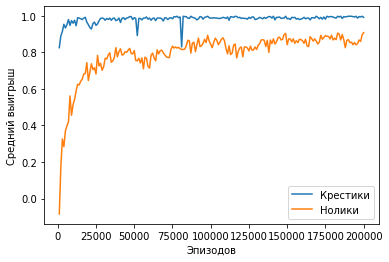

In [17]:
plot_results(results_1)
print(f'Средний выигрыш крестиков против случайной политики: {np.round(np.mean(results_1[1][-100:-1]), 3)}')
print(f'Средний выигрыш ноликов против случайной политики: {np.round(np.mean(results_1[2][-100:-1]), 3)}')

### 2. Попробуйте обучить стратегии крестиков и ноликов для доски 4х4 и/или 5х5.

In [ ]:
p_1 = Policy()
p_2 = Policy()
env = TicTacToe(4, 4, 4)

episodes = 1000000
test_each = 1000
print_each = 100000

results_2 = run_experiment(env, p_1, p_2, episodes, test_each, print_each)

 10%|█         | 100091/1000000 [05:22<1:42:10, 146.79it/s]

Episode 100000, cross reward: 0.372, nought reward: 0.018


 20%|██        | 200078/1000000 [10:35<1:32:30, 144.11it/s]

Episode 200000, cross reward: 0.498, nought reward: 0.018


 30%|███       | 300076/1000000 [15:46<1:12:42, 160.43it/s]

Episode 300000, cross reward: 0.59, nought reward: 0.074


 40%|████      | 400089/1000000 [20:54<1:06:27, 150.43it/s]

Episode 400000, cross reward: 0.29, nought reward: 0.052


 50%|█████     | 500103/1000000 [25:55<52:36, 158.35it/s]  

Episode 500000, cross reward: 0.682, nought reward: 0.15


 60%|██████    | 600122/1000000 [30:51<36:28, 182.70it/s]

Episode 600000, cross reward: 0.628, nought reward: 0.16


 70%|███████   | 700112/1000000 [35:47<29:32, 169.24it/s]

Episode 700000, cross reward: 0.742, nought reward: 0.118


 80%|████████  | 800099/1000000 [40:43<19:07, 174.16it/s]

Episode 800000, cross reward: 0.772, nought reward: 0.124


 90%|█████████ | 900081/1000000 [45:39<10:07, 164.42it/s]

Episode 900000, cross reward: 0.804, nought reward: 0.19


100%|██████████| 1000000/1000000 [50:35<00:00, 329.43it/s]

Episode 1000000, cross reward: 0.806, nought reward: 0.204


Средний выигрышь крестиков против случайной политики: 0.769
Средний выигрышь ноликов против случайной политики: 0.192


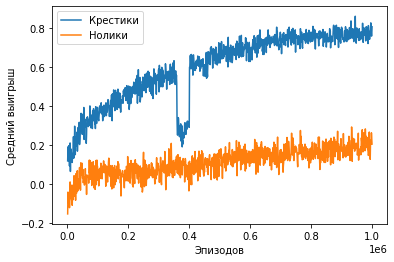

In [ ]:
plot_results(results_2)
print(f'Средний выигрыш крестиков против случайной политики: {np.round(np.mean(results_2[1][-100:-1]), 3)}')
print(f'Средний выигрыш ноликов против случайной политики: {np.round(np.mean(results_2[2][-100:-1]), 3)}')

Как видим, при увелечении размерности доски всего на 1, Q-обучение требует гораздо большее количество эпизодов - увеличение в 5 раз не дало возможности обучиться модели с таким же результатам как на доске 3х3.

In [ ]:
p_1 = Policy()
p_2 = Policy()
env = TicTacToe(5, 5, 5)

episodes = 2000000
test_each = 1000
print_each = 200000

results_3 = run_experiment(env, p_1, p_2, episodes, test_each, print_each)

 10%|█         | 200043/2000000 [21:53<11:40:31, 42.82it/s]

Episode 200000, cross reward: 0.204, nought reward: -0.072


 20%|██        | 400037/2000000 [43:21<10:28:37, 42.42it/s]

Episode 400000, cross reward: 0.308, nought reward: -0.15


 30%|███       | 600031/2000000 [1:04:42<8:43:59, 44.53it/s] 

Episode 600000, cross reward: 0.294, nought reward: -0.152


 40%|████      | 800043/2000000 [1:25:48<7:44:57, 43.01it/s] 

Episode 800000, cross reward: 0.338, nought reward: -0.128


 50%|█████     | 1000030/2000000 [1:46:55<6:34:31, 42.24it/s]

Episode 1000000, cross reward: 0.276, nought reward: -0.068


 60%|██████    | 1200043/2000000 [2:07:58<5:19:58, 41.67it/s]

Episode 1200000, cross reward: 0.306, nought reward: -0.108


 70%|███████   | 1400058/2000000 [2:29:04<3:46:02, 44.24it/s]

Episode 1400000, cross reward: 0.294, nought reward: -0.132


 80%|████████  | 1600027/2000000 [2:50:11<2:37:30, 42.32it/s]

Episode 1600000, cross reward: 0.334, nought reward: -0.094


 90%|█████████ | 1800027/2000000 [3:11:27<1:21:52, 40.71it/s]

Episode 1800000, cross reward: 0.31, nought reward: -0.124


100%|██████████| 2000000/2000000 [3:32:49<00:00, 156.62it/s]

Episode 2000000, cross reward: 0.33, nought reward: -0.082


Средний выигрышь крестиков против случайной политики: 0.306
Средний выигрышь ноликов против случайной политики: -0.097


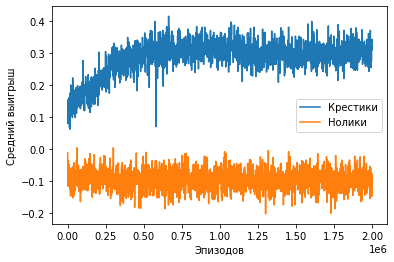

In [ ]:
plot_results(results_3)
print(f'Средний выигрыш крестиков против случайной политики: {np.round(np.mean(results_3[1][-100:-1]), 3)}')
print(f'Средний выигрыш ноликов против случайной политики: {np.round(np.mean(results_3[2][-100:-1]), 3)}')

При заданных параметрах - не получилось эффективно обучить Q-стратегию для доски размера 5х5, при этом количество эпизодов и времени потребовалось значительно больше (2 млн эпизодов и ~3 часа времени).

## Часть вторая: добавим нейронных сетей

### Реализуйте DQN с нейронной сетью
Обучите стратегии крестиков и ноликов. Замечание: скорее всего, experience replay потребуется сразу же.

In [11]:
import TicTacToeClasses
from TicTacToeClasses import TicTacToeDQN, Network, Network4x4

In [23]:
imp.reload(TicTacToeClasses)

<module 'TicTacToeClasses' from '/content/drive/My Drive/MADE/3-dl-rl/hw2/TicTacToeClasses.py'>

In [24]:
def train(model, episodes, test_each, print_each):
  indexes = [] 
  crosses_v, noughts_v = [], []
  crosses_d, noughts_d = [], []

  for i in tqdm.tqdm(range(1, episodes + 1)):
    model.run_episode()
    if i % test_each == 0:
      crosses = model.play_game(1, episodes=500)
      noughts = model.play_game(-1, episodes=500)
      indexes.append(i)
      crosses_v.append(np.mean(crosses == 1))
      noughts_v.append(np.mean(noughts == 1))
      crosses_d.append(np.mean(crosses == 0))
      noughts_d.append(np.mean(noughts == 0))
    if i % print_each == 0:
      print(f'Episode {i}, cross reward: {np.mean(crosses == 1)}, nought reward: {np.mean(noughts == 1)}')

  indexes = np.array(indexes)
  crosses_v, noughts_v = np.array(crosses_v), np.array(noughts_v)
  crosses_d, noughts_d = np.array(crosses_d), np.array(noughts_d)
  results = np.vstack((indexes, crosses_v, noughts_v, crosses_d, noughts_d))

  return results

In [25]:
def plot_results_with_draws(results):
    plt.xlabel('Эпизодов')
    plt.ylabel('Процент исходов')
    plt.plot(results[0], results[1], label='Крестики выиграли')
    plt.plot(results[0], results[2], label='Нолики выиграли')
    plt.plot(results[0], results[3], label='Крестики сыграли в ничью')
    plt.plot(results[0], results[4], label='Нолики сыграли в ничью')
    plt.legend()

In [ ]:
episodes = 30000
test_each = 1000
print_each = 6000

env = TicTacToe(3, 3, 3)
desk = Network
dqn = TicTacToeDQN(env, 3, 3, 3, desk)
results_4 = train(dqn, episodes, test_each, print_each)

 20%|██        | 6003/30000 [06:17<1:19:23,  5.04it/s]

Episode 6000, cross reward: 0.892, nought reward: 0.578


 40%|████      | 12002/30000 [12:50<1:09:09,  4.34it/s]

Episode 12000, cross reward: 0.882, nought reward: 0.634


 60%|██████    | 18004/30000 [20:08<26:29,  7.55it/s]

Episode 18000, cross reward: 0.922, nought reward: 0.58


 80%|████████  | 24002/30000 [27:07<25:04,  3.99it/s]

Episode 24000, cross reward: 0.944, nought reward: 0.634


100%|██████████| 30000/30000 [34:30<00:00, 14.49it/s]

Episode 30000, cross reward: 0.944, nought reward: 0.644


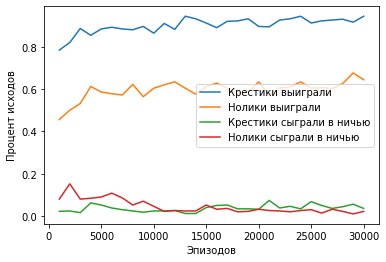

In [ ]:
plot_results_with_draws(results_4)

DQN достаточно быстро нашла оптимальную стратегию, но дальнейшее обучение происходит медленно, в сравнении с обычным Q-обучением.

In [26]:
episodes = 60000
test_each = 1000
print_each = 12000

env = TicTacToe(4, 4, 4)
desk = Network4x4
dqn = TicTacToeDQN(env, 4, 4, 4, desk)
results_4_1 = train(dqn, episodes, test_each, print_each)

 20%|██        | 12000/60000 [1:28:54<21:24:09,  1.61s/it]

Episode 12000, cross reward: 0.644, nought reward: 0.548


 40%|████      | 24000/60000 [3:05:48<14:52:05,  1.49s/it]

Episode 24000, cross reward: 0.77, nought reward: 0.672


 60%|██████    | 36000/60000 [4:25:47<8:42:21,  1.31s/it]

Episode 36000, cross reward: 0.908, nought reward: 0.704


 80%|████████  | 48000/60000 [5:44:39<4:14:41,  1.27s/it]

Episode 48000, cross reward: 0.926, nought reward: 0.732


100%|██████████| 60000/60000 [7:00:09<00:00,  2.38it/s]

Episode 60000, cross reward: 0.88, nought reward: 0.654


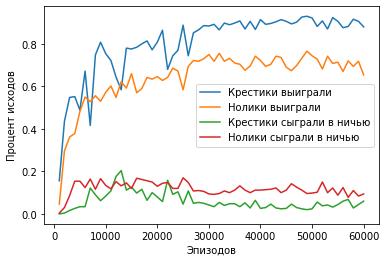

In [27]:
plot_results_with_draws(results_4_1)

Получили неплохие результаты, особенно для второго игрока, в сравнении с Q-обучением, но при этом обучение занимает много времени.

### Реализуйте Double DQN и/или Dueling DQN.

Посмотрим, улучшат ли наши результаты Double DQN и Dueling DQN

In [ ]:
imp.reload(TicTacToeClasses)
from TicTacToeClasses import TicTacToeDoubleDQN

In [ ]:
episodes = 30000
test_each = 1000
print_each = 6000

env = TicTacToe(3, 3, 3)
desk = Network
ddqn = TicTacToeDoubleDQN(env, 3, 3, 3, desk)
results_5 = train(dqn, episodes, test_each, print_each)

 20%|██        | 6003/30000 [06:38<1:33:42,  4.27it/s]

Episode 6000, cross reward: 0.942, nought reward: 0.614


 40%|████      | 12001/30000 [14:19<1:32:25,  3.25it/s]

Episode 12000, cross reward: 0.92, nought reward: 0.662


 60%|██████    | 18002/30000 [23:22<1:11:56,  2.78it/s]

Episode 18000, cross reward: 0.954, nought reward: 0.692


 80%|████████  | 24001/30000 [33:39<32:43,  3.05it/s]

Episode 24000, cross reward: 0.958, nought reward: 0.674


100%|██████████| 30000/30000 [43:31<00:00, 11.49it/s]

Episode 30000, cross reward: 0.954, nought reward: 0.65


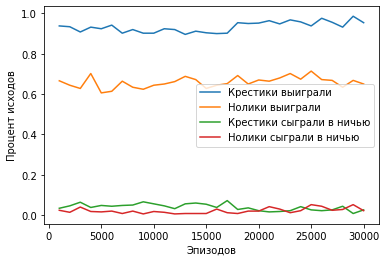

In [ ]:
plot_results_with_draws(results_5)

Double DQN еще быстрее находит оптимальную стратегию, но дальнейшее обучение также занимает много времени при небольшом росте выигрыша.

In [ ]:
imp.reload(TicTacToeClasses)
from TicTacToeClasses import DuelingNetwork

In [ ]:
episodes = 30000
test_each = 1000
print_each = 6000

env = TicTacToe(3, 3, 3)
ddesk = DuelingNetwork
ddqn = TicTacToeDoubleDQN(env, 3, 3, 3, desk)
results_6 = train(dqn, episodes, test_each, print_each)

 20%|██        | 6001/30000 [09:52<1:56:54,  3.42it/s]

Episode 6000, cross reward: 0.964, nought reward: 0.714


 40%|████      | 12001/30000 [21:20<2:23:42,  2.09it/s]

Episode 12000, cross reward: 0.976, nought reward: 0.628


 60%|██████    | 18001/30000 [34:01<1:28:53,  2.25it/s]

Episode 18000, cross reward: 0.966, nought reward: 0.676


 80%|████████  | 24001/30000 [48:26<48:03,  2.08it/s]  

Episode 24000, cross reward: 0.952, nought reward: 0.636


100%|██████████| 30000/30000 [1:01:52<00:00,  8.08it/s]

Episode 30000, cross reward: 0.964, nought reward: 0.61


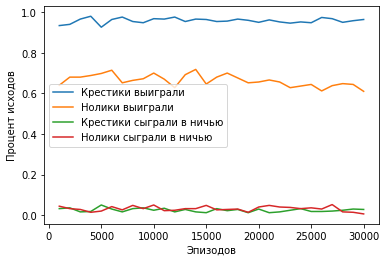

In [ ]:
plot_results_with_draws(results_6)

Комбинирование Double и Dueling улучшило предыдущие результаты, но в целом проблемы сохранились.

## Часть третья: расширим и углубим поиск

###Реализуйте rollouts со случайной стратегией 
И (опционально) rollouts с неслучайной, но простой стратегией (например, основанной на дополнении нескольких паттернов или на Q-функции, которая у вас получилась в первом пункте).

In [ ]:
def do_rollouts(env, action, p_1=None, p_2=None, rollouts=100):

  rewards = []
  for i in range(rollouts):
    env_copy = copy.deepcopy(env)
    (board_hash, empty_spaces, cur_turn), reward, done, _ = env_copy.step(action)

    while not done:
      if cur_turn == 1:
        a, idx = get_action_g(p_1, board_hash, empty_spaces)
        state, reward, done, _ = env_copy.step(a)
        board_hash_main, empty_spaces_main, cur_turn_main = state
      elif cur_turn == -1:
        a, idx = get_action_g(p_2, board_hash, empty_spaces)
        state, reward, done, _ = env_copy.step(a)
        board_hash_main, empty_spaces_main, cur_turn_main = state
      else:
        raise Exception('Может быть только 2 игрока')
    
      board_hash, empty_spaces, cur_turn = board_hash_main, empty_spaces_main, cur_turn_main

    rewards.append(reward)  
  return np.array(reward).mean()

In [ ]:
def play_with_rollouts(env, p_1=None, p_2=None, mode="normal"):
  env.reset()
  board_hash, empty_spaces, cur_turn = env.getState()
  reward, done = 0, False

  if mode == "random":
    p_1, p_2 = "pass", "pass"

  while not done:
    if cur_turn == 1:
      if p_1:
        if mode == "random":
          p_1 = None
        idx, best_reward = 0, -10
        for i, action in enumerate(empty_spaces):
          avg_reward = do_rollouts(env, action, p_1, None)
          if avg_reward > best_reward:
            idx, best_reward = i, avg_reward
      else:
        idx = np.random.randint(len(empty_spaces))
      a = empty_spaces[idx]
      state, reward, done, _ = env.step(a)
      board_hash_main, empty_spaces_main, cur_turn_main = state
    elif cur_turn == -1:
      if p_2:
        if mode == "random":
          p_2 = None
        idx, best_reward = 0, -10
        for i, action in enumerate(empty_spaces):
          avg_reward = do_rollouts(env, action, None, p_2)
          if avg_reward > best_reward:
            idx, best_reward = i, avg_reward
      else:
        idx = np.random.randint(len(empty_spaces))
      a = empty_spaces[idx]
      state, reward, done, _ = env.step(a)
      board_hash_main, empty_spaces_main, cur_turn_main = state
    else:
      raise Exception('Может быть только 2 игрока')

    board_hash, empty_spaces, cur_turn = board_hash_main, empty_spaces_main, cur_turn_main

  return reward
    

In [ ]:
def run_experiment_with_rollouts(env, p_1, p_2, episodes, mode="normal"):
  rewards = []
  for i in tqdm.tqdm(range(1, episodes + 1)):
    reward = play_with_rollouts(env, p_1, p_2, mode=mode)
    rewards.append(reward)

  return rewards

In [ ]:
def run_random_experiment(env, episodes):
  rewards = []
  for i in tqdm.tqdm(range(1, episodes + 1)):
    reward = play_game(env)
    rewards.append(reward)

  return rewards

**Сперва проведем эксперимент с просто рандомными ходами двух игроков.**

In [ ]:
env = TicTacToe(3, 3, 3)
episodes = 10000

results_9 = run_random_experiment(env, episodes)

100%|██████████| 10000/10000 [00:06<00:00, 1654.34it/s]


In [ ]:
print(f'Средний выигрыш крестиков: {np.round(np.mean(results_9), 3)}')

Средний выигрыш крестиков: 0.292


**Как мы видим, первый ход имеет большое значение в игре 3х3.** Посмотрим, как скажется наличие роллаутов для двух игроков.

In [ ]:
episodes = 200

results_10 = run_experiment_with_rollouts(env, None, None, episodes, mode="random")

100%|██████████| 200/200 [03:12<00:00,  1.04it/s]


In [ ]:
print(f'Средний выигрыш крестиков: {np.round(np.mean(results_10), 3)}')

Средний выигрыш крестиков: 0.265


Проведя несколько экспериментов с роллаутами можно заметить, что выигрыш крестиков не превышает средний выигрыш при полностью рандомной игре. Это объясняется тем, что действия при роллауте также являются рандомными и не дают явного преимущества. Но это должно измениться, если применим к роллауты к политикам, даже если они слабообученны.


In [ ]:
p_1 = Policy()
p_2 = Policy()

episodes = 200
test_each = 10
print_each = 40

results_11 = run_experiment(env, p_1, p_2, episodes, test_each, print_each)

 20%|██        | 40/200 [00:02<00:10, 15.40it/s]

Episode 40, cross reward: 0.29, nought reward: -0.324


 45%|████▌     | 90/200 [00:05<00:07, 15.13it/s]

Episode 80, cross reward: 0.432, nought reward: -0.332


 65%|██████▌   | 130/200 [00:08<00:04, 14.68it/s]

Episode 120, cross reward: 0.332, nought reward: -0.342


 80%|████████  | 160/200 [00:10<00:02, 14.71it/s]

Episode 160, cross reward: 0.378, nought reward: -0.262


100%|██████████| 200/200 [00:13<00:00, 15.05it/s]

Episode 200, cross reward: 0.496, nought reward: -0.22


In [ ]:
print(f'Средний выигрыш крестиков против случайной политики: {np.round(np.mean(results_11[1]), 3)}')
print(f'Средний выигрыш ноликов против случайной политики: {np.round(np.mean(results_11[2]), 3)}')

Средний выигрыш крестиков против случайной политики: 0.368
Средний выигрыш ноликов против случайной политики: -0.284


In [ ]:
episodes = 100

results_12 = run_experiment_with_rollouts(env, p_1, None, episodes)
print(f'Средний выигрыш крестиков: {np.round(np.mean(results_12), 3)}')

100%|██████████| 100/100 [01:45<00:00,  1.06s/it]

Средний выигрыш крестиков: 0.77


In [ ]:
results_13 = run_experiment_with_rollouts(env, None, p_2, episodes)
print(f'Средний выигрыш ноликов: {np.round(np.mean(results_13), 3)}')

100%|██████████| 100/100 [01:18<00:00,  1.27it/s]

Средний выигрыш ноликов: 0.81


**Роллауты существенно улучшили результат за короткое время.** Но если Q-обучение достаточно хорошо обучилось на большом количестве игр на доске 3х3, то с досками больших размерностей были проблемы.

In [ ]:
env = TicTacToe(4, 4, 4)
p_1 = Policy()
p_2 = Policy()

episodes = 1000
test_each = 100
print_each = 200

results_14 = run_experiment(env, p_1, p_2, episodes, test_each, print_each)

 20%|██        | 200/1000 [00:29<01:57,  6.78it/s]

Episode 200, cross reward: 0.102, nought reward: -0.074


 40%|████      | 400/1000 [00:59<01:29,  6.67it/s]

Episode 400, cross reward: 0.068, nought reward: -0.05


 60%|██████    | 600/1000 [01:29<01:00,  6.66it/s]

Episode 600, cross reward: 0.102, nought reward: 0.014


 80%|████████  | 800/1000 [01:58<00:29,  6.74it/s]

Episode 800, cross reward: 0.126, nought reward: -0.046


100%|██████████| 1000/1000 [02:28<00:00,  6.73it/s]

Episode 1000, cross reward: 0.096, nought reward: -0.052


In [ ]:
print(f'Средний выигрыш крестиков против случайной политики: {np.round(np.mean(results_14[1]), 3)}')
print(f'Средний выигрыш ноликов против случайной политики: {np.round(np.mean(results_14[2]), 3)}')

Средний выигрыш крестиков против случайной политики: 0.077
Средний выигрыш ноликов против случайной политики: -0.046


In [ ]:
episodes = 100

results_15 = run_experiment_with_rollouts(env, p_1, None, episodes)
print(f'Средний выигрыш крестиков: {np.round(np.mean(results_15), 3)}')

100%|██████████| 100/100 [11:28<00:00,  6.89s/it]

Средний выигрыш крестиков: 0.72


In [ ]:
results_16 = run_experiment_with_rollouts(env, None, p_2, episodes)
print(f'Средний выигрыш ноликов: {np.round(np.mean(results_16), 3)}')

100%|██████████| 100/100 [09:56<00:00,  5.97s/it]

Средний выигрыш ноликов: 0.38


**То, на что нам потребовалось 50 минут было достигнуто за 20 минут.** Также проверим как обстоят дела с доской 5х5

In [ ]:
env = TicTacToe(5, 5, 5)
p_1 = Policy()
p_2 = Policy()

episodes = 10000
test_each = 1000
print_each = 2000

results_17 = run_experiment(env, p_1, p_2, episodes, test_each, print_each)

 20%|██        | 2049/10000 [00:12<03:09, 41.94it/s]

Episode 2000, cross reward: 0.026, nought reward: -0.08


 40%|████      | 4034/10000 [00:25<02:25, 40.99it/s]

Episode 4000, cross reward: 0.08, nought reward: -0.096


 60%|██████    | 6049/10000 [00:38<01:39, 39.80it/s]

Episode 6000, cross reward: 0.136, nought reward: -0.11


 81%|████████  | 8052/10000 [00:51<00:48, 39.80it/s]

Episode 8000, cross reward: 0.128, nought reward: -0.156


100%|██████████| 10000/10000 [01:04<00:00, 155.41it/s]

Episode 10000, cross reward: 0.118, nought reward: -0.094


In [ ]:
print(f'Средний выигрыш крестиков против случайной политики: {np.round(np.mean(results_17[1]), 3)}')
print(f'Средний выигрыш ноликов против случайной политики: {np.round(np.mean(results_17[2]), 3)}')

Средний выигрыш крестиков против случайной политики: 0.107
Средний выигрыш ноликов против случайной политики: -0.092


In [ ]:
episodes = 100

results_18 = run_experiment_with_rollouts(env, p_1, None, episodes)
print(f'Средний выигрыш крестиков: {np.round(np.mean(results_18), 3)}')

100%|██████████| 100/100 [52:22<00:00, 31.43s/it]

Средний выигрыш крестиков: 0.61


In [ ]:
results_19 = run_experiment_with_rollouts(env, None, p_2, episodes)
print(f'Средний выигрыш ноликов: {np.round(np.mean(results_19), 3)}')

100%|██████████| 100/100 [48:39<00:00, 29.20s/it]

Средний выигрыш ноликов: 0.79


Роллауты позволяют нам повышать качество моделей, экономя вычислительные и  временные ресурсы.

### Реализуйте MCTS-поиск с этими rollouts 
Для крестиков-ноликов на досках разного размера, сравните полученные стратегии между собой и со стратегиями, обученными в первых двух частях.

In [17]:
imp.reload(TicTacToeClasses)

<module 'TicTacToeClasses' from '/content/drive/My Drive/MADE/3-dl-rl/hw2/TicTacToeClasses.py'>

In [18]:
from TicTacToeClasses import MCTS

In [19]:
def train_mcts(model, episodes, test_each, print_each, player):
  indexes = [] 
  player_v, player_d = [], []
  rewards = {1: 0, 0: 0, -1: 0}

  for i in tqdm.tqdm(range(1, episodes + 1)):
    # model.learn()
    model.learn_episode()
    if i % test_each == 0:
      rewards = {1: 0, 0: 0, -1: 0}
      for _ in range(1000):
        # reward, positions = model.play_game()
        reward, positions = model.test_game()
        rewards[reward] += 1
      indexes.append(i)
      player_v.append(rewards[player] / 1000)
      player_d.append(rewards[0] / 1000)
    if i % print_each == 0:
      print(f'Episode {i}, cross reward: {rewards[player] / 1000}')

  indexes = np.array(indexes)
  player_v = np.array(player_v)
  player_d = np.array(player_d)
  results = np.vstack((indexes, player_v, player_d))

  return results

In [21]:
def plot_mcts_results_with_draws(cross_results, noughts_results):
    plt.xlabel('Эпизодов')
    plt.ylabel('Процент исходов')
    plt.plot(cross_results[0], cross_results[1], label='Крестики выиграли')
    plt.plot(cross_results[0], cross_results[2], label='Крестики сыграли в ничью')
    plt.plot(cross_results[0], noughts_results[1], label='Нолики выиграли')
    plt.plot(cross_results[0], noughts_results[2], label='Нолики сыграли в ничью')
    plt.legend()

**Обучим модель на доске 3х3**

In [22]:
episodes = 100000
test_each = 1000
print_each = 20000

env = TicTacToe(3, 3, 3)
player = 1
mcts_1 = MCTS(env, player, 1)
results_20 = train_mcts(mcts_1, episodes, test_each, print_each, player)

 20%|██        | 20302/100000 [00:22<01:41, 788.57it/s]

Episode 20000, cross reward: 0.975


 40%|████      | 40269/100000 [00:43<01:13, 808.40it/s]

Episode 40000, cross reward: 0.986


 60%|██████    | 60231/100000 [01:04<00:50, 781.45it/s]

Episode 60000, cross reward: 0.986


 80%|████████  | 80154/100000 [01:26<00:26, 737.20it/s]

Episode 80000, cross reward: 0.986


100%|██████████| 100000/100000 [01:47<00:00, 933.72it/s]

Episode 100000, cross reward: 0.991


In [23]:
player = -1
mcts_2 = MCTS(env, player, 1)
results_21 = train_mcts(mcts_2, episodes, test_each, print_each, player)

 20%|██        | 20203/100000 [00:24<01:59, 669.69it/s]

Episode 20000, cross reward: 0.78


 40%|████      | 40142/100000 [00:47<01:28, 680.12it/s]

Episode 40000, cross reward: 0.908


 60%|██████    | 60283/100000 [01:10<00:54, 734.23it/s]

Episode 60000, cross reward: 0.936


 80%|████████  | 80255/100000 [01:33<00:27, 724.58it/s]

Episode 80000, cross reward: 0.927


100%|██████████| 100000/100000 [01:55<00:00, 862.89it/s]

Episode 100000, cross reward: 0.931


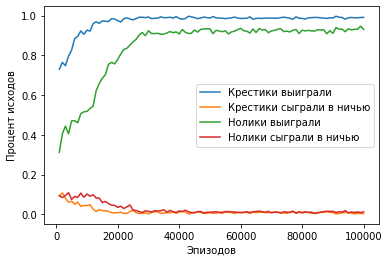

In [24]:
plot_mcts_results_with_draws(results_20, results_21)

Разница в скорости и качестве разительно отличается от DQN. Но если для доски 3х3 мы получили хорошие результаты быстро при помощи обычного Q-обучения, то с досками большей размерности были трудности, так как обучение требовало очень много времени.
**Посмотрим как MCTS покажет себя на доске 4x4.**

In [25]:
episodes = 2000000
test_each = 20000
print_each = 400000

env = TicTacToe(4, 4, 4)
player = 1
mcts_1 = MCTS(env, player, 1)
results_22 = train_mcts(mcts_1, episodes, test_each, print_each, player)

 20%|██        | 400078/2000000 [11:23<2:23:43, 185.54it/s]

Episode 400000, cross reward: 0.609


 40%|████      | 800139/2000000 [21:48<1:13:25, 272.33it/s]

Episode 800000, cross reward: 0.867


 60%|██████    | 1200082/2000000 [31:09<46:58, 283.77it/s]

Episode 1200000, cross reward: 0.863


 80%|████████  | 1600093/2000000 [39:59<22:04, 301.85it/s]

Episode 1600000, cross reward: 0.888


100%|██████████| 2000000/2000000 [48:38<00:00, 685.32it/s]

Episode 2000000, cross reward: 0.923


In [26]:
player = -1
mcts_2 = MCTS(env, player, 1)
results_23 = train_mcts(mcts_2, episodes, test_each, print_each, player)

 20%|██        | 400065/2000000 [10:58<2:35:42, 171.26it/s]

Episode 400000, cross reward: 0.345


 40%|████      | 800113/2000000 [22:16<2:02:10, 163.69it/s]

Episode 800000, cross reward: 0.385


 60%|██████    | 1200087/2000000 [33:56<1:23:03, 160.52it/s]

Episode 1200000, cross reward: 0.46


 80%|████████  | 1600116/2000000 [45:40<41:41, 159.89it/s]

Episode 1600000, cross reward: 0.474


100%|██████████| 2000000/2000000 [57:31<00:00, 579.43it/s]

Episode 2000000, cross reward: 0.456


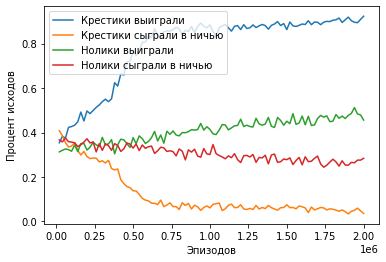

In [27]:
plot_mcts_results_with_draws(results_22, results_23)

Тут явное преимущество в сравнении с Q-обучением и DQN - как в скорости, так и качестве обучения. Единственное, нолики обучаются более медленно.

Обучение для доски 5х5 требует значительно большего количества эпизодов и соответственно времени.